In [186]:
import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns 
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import datetime as dt
import random
import os 
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, GRU,LSTM, Dense,Lambda,Conv1D
from pandas.tseries.offsets import DateOffset
from keras.layers import AdditiveAttention
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from fastprogress import master_bar, progress_bar
from tqdm import tqdm
import glob
from torchsummary import summary
from sklearn.metrics import mean_absolute_percentage_error
from pytorch_tcn import TCN

TRAIN_STEPS = 168
OUTPUT_STEPS = 1
OFFSET = 1
LSTM_DIM = 64
MAX_EPOCH = 200
BATCH_SIZE = 32
LEA_RAT = 0.01


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cpu


In [187]:
FILE_DIR = r'C:\\Users\\Zain Ahmed\\Desktop\\Newest Paper\\*.csv'
data = pd.DataFrame()

METRO_FILE_DIR = r'C:\\Users\\Zain Ahmed\\Desktop\\Newest Paper\\Metrodata\\*.csv'
metro_data = pd.DataFrame()

In [188]:
for i in range(len(glob.glob(FILE_DIR))):
    df = pd.read_csv(glob.glob(FILE_DIR)[i])
    data = pd.concat([data,df],ignore_index=True)
    
for i in range(len(glob.glob(METRO_FILE_DIR))):
    metro_df = pd.read_csv(glob.glob(METRO_FILE_DIR)[i],skiprows=2)
    metro_data = pd.concat([metro_data,metro_df],ignore_index=True)
    

In [189]:
metro_data = metro_data[metro_data['Minute'] != 30]

In [190]:
metro_data
data['datetime'] = data['Year'].astype('str') +  '-' + data['Month'].astype('str') + '-' + data['Day'].astype('str') + '-' + data['Hour'].astype('str')


In [191]:
data

,campus,bldgno,bldgname,tstamp,Year,Month,Day,Hour,KW,KWS,...,HTmmBTU#Houses,HTmmBTUlightbulbs,HTmmBTUgalsgas,Total#Houses,Totallightbulbs,Totalgalsgas,GHG,DOW,tstamp2,datetime
0,Tempe,NaN,,,2016,1,1,0,16333.65,1.32,...,1206.0,301459.0,115.0,7769.0,1942125.0,16668.0,8.868,6,2016-01-01T00:00:00.000,2016-1-1-0
1,Tempe,NaN,,,2016,1,1,1,16228.42,1.29,...,1232.0,308012.0,118.0,7734.0,1933276.0,16406.0,8.811,6,2016-01-01T01:00:00.000,2016-1-1-1
2,Tempe,NaN,,,2016,1,1,2,16397.60,1.30,...,1252.0,312852.0,120.0,7723.0,1930582.0,15798.0,8.903,6,2016-01-01T02:00:00.000,2016-1-1-2
3,Tempe,NaN,,,2016,1,1,3,16317.28,1.32,...,1286.0,321361.0,123.0,7592.0,1897781.0,14657.0,8.859,6,2016-01-01T03:00:00.000,2016-1-1-3
4,Tempe,NaN,,,2016,1,1,4,16316.95,1.30,...,1311.0,327655.0,125.0,7620.0,1904866.0,14683.0,8.862,6,2016-01-01T04:00:00.000,2016-1-1-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35058,Tempe,NaN,,,2019,12,31,19,15116.80,0.94,...,1007.0,251720.0,96.0,7329.0,1832042.0,17397.0,8.207,3,2019-12-31T19:00:00.000,2019-12-31-19
35059,Tempe,NaN,,,2019,12,31,20,14852.98,0.95,...,1039.0,259767.0,99.0,7233.0,1808063.0,16952.0,8.066,3,2019-12-31T20:00:00.000,2019-12-31-20
35060,Tempe,NaN,,,2019,12,31,21,14680.53,0.90,...,1065.0,266104.0,102.0,7101.0,1774987.0,16072.0,7.966,3,2019-12-31T21:00:00.000,2019-12-31-21
35061,Tempe,NaN,,,2019,12,31,22,14359.63,0.83,...,1015.0,253571.0,97.0,6880.0,1719802.0,15413.0,7.798,3,2019-12-31T22:00:00.000,2019-12-31-22


In [192]:
data['datetime'] = data['Year'].astype('str') +  '-' + data['Month'].astype('str') + '-' + data['Day'].astype('str') + '-' + data['Hour'].astype('str')
data['datetime']=pd.to_datetime(data['datetime'],format='%Y-%m-%d-%H')


metro_data['datetime'] = metro_data['Year'].astype('str') +  '-' + metro_data['Month'].astype('str') + '-' + metro_data['Day'].astype('str') + '-' + metro_data['Hour'].astype('str')
metro_data['datetime']=pd.to_datetime(metro_data['datetime'],format='%Y-%m-%d-%H')

In [193]:
data = data.set_index('datetime')
metro_data = metro_data.set_index('datetime')


In [194]:
data = data[['KW','HTmmBTU','CHWTON']]
Qu_1 = data.quantile(0.25)
Qu_3 = data.quantile(0.75)
IQR = Qu_3 - Qu_1
((data<(Qu_1 - 3.0 * IQR)) | (data>(Qu_3 + 2.0 * IQR))).sum()

KW           7
HTmmBTU    141
CHWTON       0
dtype: int64

In [195]:
#data[(data<(Qu_1 - 2.0 * IQR) | (data>(Qu_3 - 2.0 * IQR)))] 

In [196]:
data[((data<(Qu_1 - 2.0 * IQR)) | (data>(Qu_3 + 2.0 * IQR)))] = np.nan 
data.loc[data['KW']==0,'KW'] = np.nan
data.loc[data['HTmmBTU']==0,'HTmmBTU'] = np.nan
data.loc[data['CHWTON']==0,'CHWTON'] = np.nan

data.fillna(method='ffill',inplace=True)

In [197]:
merge=pd.merge(data,metro_data, how='inner', left_index=True, right_index=True)


In [198]:
data = merge
data['HTmmBTU'] = data['HTmmBTU'] * 293.07
data['CHWTON'] = data['CHWTON'] * 3.52

In [199]:
data['KW_last_hour'] = data['KW'].shift()
data['HTmmBTU_last_hour'] = data['HTmmBTU'].shift()
data['CHWTON_last_hour'] = data['CHWTON'].shift()
data['KW_last_2_hour'] = data['KW'].shift(2)
data['HTmmBTU_last_2_hour'] = data['HTmmBTU'].shift(2)
data['CHWTON_last_2_hour'] = data['CHWTON'].shift(2)
data['KW_last_day'] = data['KW'].shift(24)
data['HTmmBTU_last_day'] = data['HTmmBTU'].shift(24)
data['CHWTON_last_day'] = data['CHWTON'].shift(24)
data['KW_last_week'] = data['KW'].shift(168)
data['HTmmBTU_last_week'] = data['HTmmBTU'].shift(168)
data['CHWTON_last_week'] = data['CHWTON'].shift(168)
data['KW_last_year'] = data.groupby([data.index.month,data.index.day,data.index.hour])['KW'].shift()
data['HTmmBTU_last_year'] = data.groupby([data.index.month,data.index.day,data.index.hour])['HTmmBTU'].shift()
data['CHWTON_last_year'] = data.groupby([data.index.month,data.index.day,data.index.hour])['CHWTON'].shift()
data.fillna(method='bfill',inplace=True)

In [200]:
# Now we will divide the data 

In [201]:
(data['HTmmBTU'] == 0).sum()

0

In [202]:

spring_data = data[(data['Month']>2) & (data['Month']<6)]
spring_data.name = 'spring_data'


summer_data = data[(data['Month']>5) & (data['Month']<9)]
summer_data.name = 'summer_data'


autumn_data = data[(data['Month']>8) & (data['Month']<12)]
autumn_data.name = 'autumn_data'



winter_data = data[(data['Month']>11) | (data['Month']<3)]
winter_data.name = 'winter_data'
    

def rolling_window(array_data_real,input_size,output_size,offset,out=[],inp=['C','H','E']):
    '''
    The function takes a series array_data of size (size,) 

    and generates
    
    a array of size (input_size,((array_size-(input_size+output_size)/stride)+1)) as inputs 
    
    and array of size (array_size-(input_size+output_size)/stride)+1)as output 
    
    '''
    
    array_data = array_data_real.copy(deep=True) 
    
    scaler = MinMaxScaler()
    
    scaler = scaler.fit(array_data)
    
    array_data_scaled = pd.DataFrame(scaler.transform(array_data),columns = array_data.columns)
    
    if ('C' not in inp) & ('C' not in out):        
        array_data_scaled.drop('CHWTON',inplace=True,axis=1)
        array_data_scaled.drop('CHWTON_last_hour',inplace=True,axis=1)
        array_data_scaled.drop('CHWTON_last_2_hour',inplace=True,axis=1)
        array_data_scaled.drop('CHWTON_last_day',inplace=True,axis=1)
        array_data_scaled.drop('CHWTON_last_week',inplace=True,axis=1)
        array_data_scaled.drop('CHWTON_last_year',inplace=True,axis=1)


        
    if ('H' not in inp) & ('H' not in out):
            
        array_data_scaled.drop('HTmmBTU',inplace=True,axis=1)
        array_data_scaled.drop('HTmmBTU_last_hour',inplace=True,axis=1)
        array_data_scaled.drop('HTmmBTU_last_2_hour',inplace=True,axis=1)
        array_data_scaled.drop('HTmmBTU_last_day',inplace=True,axis=1)
        array_data_scaled.drop('HTmmBTU_last_week',inplace=True,axis=1)
        array_data_scaled.drop('HTmmBTU_last_year',inplace=True,axis=1)


        
    if ('E' not in inp) & ('E' not in out):   
        array_data_scaled.drop('KW',inplace=True,axis=1)
        array_data_scaled.drop('KW_last_hour',inplace=True,axis=1)
        array_data_scaled.drop('KW_last_2_hour',inplace=True,axis=1)
        array_data_scaled.drop('KW_last_day',inplace=True,axis=1)
        array_data_scaled.drop('KW_last_week',inplace=True,axis=1)
        array_data_scaled.drop('KW_last_year',inplace=True,axis=1)

            

#     lab_data = array_data[:,0]
    
#     for i in range(input_size,len(array_data)-output_size+1,offset):
            
#             data.append(array_data[i-input_size:i,0:array_data.shape[1]])
    
#             labels.append(lab_data[i:i+output_size])

        
    data_idx = sliding_window_view(np.arange(array_data_scaled.to_numpy().shape[0]).reshape(-1),window_shape=input_size)[::offset][:-1]
    
    data = array_data_scaled.to_numpy()[data_idx]
    
    if 'C' in out:
        
        out_array = array_data_scaled['CHWTON'].to_numpy()
        
        labels = sliding_window_view(out_array[input_size:].reshape(-1),window_shape=output_size)[::offset]
        
    if 'H' in out:
        
        out_array = array_data_scaled['HTmmBTU'].to_numpy()

        labels = sliding_window_view(out_array[input_size:].reshape(-1),window_shape=output_size)[::offset]
    
    if 'E' in out:
        
        out_array = array_data_scaled['KW'].to_numpy()

        labels = sliding_window_view(out_array[input_size:].reshape(-1),window_shape=output_size)[::offset]
    
    data = data.astype(np.float64)
        
    labels = labels.astype(np.float64)
        
    return data,labels,scaler,array_data

In [204]:
##Spring Data

tr_id = int((autumn_data.shape[0]*0.80)/24)*24
val_id = int((autumn_data.shape[0]*0.90)/24)*24
tra_data = autumn_data.iloc[:tr_id,:]
val_data = autumn_data.iloc[tr_id:val_id,:]
tes_data = autumn_data.iloc[val_id:,:]




In [205]:
# We will start with the Summer Data. The Heat Map for summer data shows a high MIC between Electric and 
## Cooling load so we will utilize that alongwith other factors  

In [206]:
## Heating Summer Data

heat_tra_data_sli,heat_tra_lab,heat_tra_sca,heat_tra_stan = rolling_window(tra_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['H'],inp=['C','H','E'])
heat_val_data_sli,heat_val_lab,heat_val_sca,heat_val_stan = rolling_window(val_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['H'],inp=['C','H','E'])
heat_tes_data_sli,heat_tes_lab,heat_test_scaler,heat_tes_stan = rolling_window(tes_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['H'],inp=['C','H','E'])

## Cooling Data Summer

cool_tra_data_sli,cool_tra_lab,cool_tra_sca,col_tra_stan = rolling_window(tra_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['C'],inp=['C','H','E'])
cool_val_data_sli,cool_val_lab,cool_val_sca,cool_val_stan = rolling_window(val_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['C'],inp=['C','H','E'])
cool_tes_data_sli,cool_tes_lab,cool_test_scaler,cool_tes_stan = rolling_window(tes_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['C'],inp=['C','H','E'])

## Electric Data Summer

elec_tra_data_sli,elec_tra_lab,elec_tra_sca,elec_tra_stan = rolling_window(tra_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['E'],inp=['C','H','E'])
elec_val_data_sli,elec_val_lab,elec_val_sca,elec_val_stan = rolling_window(val_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['E'],inp=['C','H','E'])
elec_tes_data_sli,elec_tes_lab,elec_test_scaler,elec_tes_stan = rolling_window(tes_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['E'],inp=['C','H','E'])

In [207]:
def array_to_dataset(x1,y1,x2,y2,x3,y3,b_size):
    
    '''
    Takes inputs and labels for 3 different datasets and returns a dataloader object
    
    x1,y1 = heat
    
    x2,y2 = cool
    
    x3,y3 = elec
    '''
    
    x1_tensor = torch.from_numpy(x1).float()
    
    y1_tensor = torch.from_numpy(y1).float()
    
    x2_tensor = torch.from_numpy(x2).float()
    
    y2_tensor = torch.from_numpy(y2).float()
    
    x3_tensor = torch.from_numpy(x3).float()
    
    y3_tensor = torch.from_numpy(y3).float()
    
    dataset = TensorDataset(x1_tensor,y1_tensor,x2_tensor,y2_tensor,x3_tensor,y3_tensor)
    
    my_dataloader = DataLoader(dataset,batch_size=b_size)
    
    return my_dataloader

In [208]:
train_dataloader = array_to_dataset(heat_tra_data_sli,heat_tra_lab,cool_tra_data_sli,cool_tra_lab,elec_tra_data_sli,elec_tra_lab,b_size=BATCH_SIZE)

In [209]:
val_dataloader = array_to_dataset(heat_val_data_sli,heat_val_lab,cool_val_data_sli,cool_val_lab,elec_val_data_sli,elec_val_lab,b_size=BATCH_SIZE)

In [210]:
tes_dataloader = array_to_dataset(heat_tes_data_sli,heat_tes_lab,cool_tes_data_sli,cool_tes_lab,elec_tes_data_sli,elec_tes_lab,b_size=BATCH_SIZE)

In [211]:
#heat_loader_train = array_to_dataloader(heat_tra_data_sli,heat_tra_lab,b_size=BATCH_SIZE)
#heat_loader_val = array_to_dataloader(heat_val_data_sli,cool_val_lab,b_size=BATCH_SIZE)

In [212]:
#cool_loader_train = array_to_dataloader(cool_tra_data_sli,cool_tra_lab,b_size=BATCH_SIZE)
#cool_loader_val = array_to_dataloader(cool_val_data_sli,cool_val_lab,b_size=BATCH_SIZE)


In [213]:
#elec_loader_train = array_to_dataloader(elec_tra_data_sli,elec_tra_lab,b_size=BATCH_SIZE)
#elec_loader_val = array_to_dataloader(elec_val_data_sli,elec_val_lab,b_size=BATCH_SIZE)


In [214]:
#dataset = torch.utils.data.TensorDataset(heat_loader_train, heat_loader_val,cool_loader_train,cool_loader_val,elec_loader_train,elec_loader_val)


In [215]:
class my_model(torch.nn.Module):
    
    def __init__(self,train_steps,heat_feature,cool_feature,elec_feature,lstm_dim):
        
        super().__init__()
        
        self.train_steps = train_steps
        
        self.heat_feature = heat_feature
        
        self.cool_feature = cool_feature
        
        self.elec_feature = elec_feature
        
        self.lstm_dim = lstm_dim
        
        self.input_1 = TCN(num_inputs=heat_feature,num_channels=[32,self.lstm_dim],kernel_size=8,dropout=0.2,input_shape= 'NLC',use_skip_connections='True',activation='leaky_relu')
        
        self.input_2 = TCN(num_inputs=cool_feature,num_channels=[32,self.lstm_dim],kernel_size=8,dropout=0.2,input_shape= 'NLC',use_skip_connections='True',activation='leaky_relu')
        
        self.input_3 = TCN(num_inputs=elec_feature,num_channels=[32,self.lstm_dim],kernel_size=8,dropout=0.2,input_shape= 'NLC',use_skip_connections='True',activation='leaky_relu')
        
        self.flatten_layer = nn.Flatten(start_dim=1)
        
        self.fully = nn.Linear(3*self.lstm_dim,3)
        
        ####USING LEAKY RELU
        
        self.relu = nn.LeakyReLU()
                
    def forward(self,heat_input,cool_input,elec_input):
        
        out_hea = self.input_1(heat_input)
        
        out_coo = self.input_2(cool_input)

        out_ele = self.input_3(elec_input)
        
#        print('Output Layer Shape is ',out_hea.shape)

        concat_layer = torch.cat((self.flatten_layer(out_hea[:,-1,:]),self.flatten_layer(out_coo[:,-1,:]),self.flatten_layer(out_ele[:,-1,:])),1)
        
#        print('Concat Layer Shape is ',concat_layer.shape)

        feature_sharing_layer = self.fully(concat_layer)
        
        final_output = self.relu(feature_sharing_layer)
        
#        print('Final Output Shape is ',final_output.shape)
        
        output_heat = final_output[:,0].unsqueeze(1)
        
#        print('Heat Output Shape is ',output_heat.shape)
        
        output_cool = final_output[:,1].unsqueeze(1)
        
        output_elec = final_output[:,2].unsqueeze(1)
        
        return output_heat,output_cool,output_elec
    
HEA_FEA = int(heat_tra_data_sli.shape[2])
COO_FEA = int(cool_tra_data_sli.shape[2])
ELE_FEA = int(elec_tra_data_sli.shape[2])


In [216]:
model = my_model(TRAIN_STEPS,HEA_FEA,COO_FEA,ELE_FEA,LSTM_DIM)
#
summary(model)

Layer (type:depth-idx)                        Param #
├─TCN: 1-1                                    --
|    └─ModuleList: 2-1                        --
|    |    └─Conv1d: 3-1                       2,112
|    └─LeakyReLU: 2-2                         --
|    └─ModuleList: 2-3                        --
|    |    └─TemporalBlock: 3-2                16,704
|    |    └─TemporalBlock: 3-3                51,520
├─TCN: 1-2                                    --
|    └─ModuleList: 2-4                        --
|    |    └─Conv1d: 3-4                       2,112
|    └─LeakyReLU: 2-5                         --
|    └─ModuleList: 2-6                        --
|    |    └─TemporalBlock: 3-5                16,704
|    |    └─TemporalBlock: 3-6                51,520
├─TCN: 1-3                                    --
|    └─ModuleList: 2-7                        --
|    |    └─Conv1d: 3-7                       2,112
|    └─LeakyReLU: 2-8                         --
|    └─ModuleList: 2-9                 

Layer (type:depth-idx)                        Param #
├─TCN: 1-1                                    --
|    └─ModuleList: 2-1                        --
|    |    └─Conv1d: 3-1                       2,112
|    └─LeakyReLU: 2-2                         --
|    └─ModuleList: 2-3                        --
|    |    └─TemporalBlock: 3-2                16,704
|    |    └─TemporalBlock: 3-3                51,520
├─TCN: 1-2                                    --
|    └─ModuleList: 2-4                        --
|    |    └─Conv1d: 3-4                       2,112
|    └─LeakyReLU: 2-5                         --
|    └─ModuleList: 2-6                        --
|    |    └─TemporalBlock: 3-5                16,704
|    |    └─TemporalBlock: 3-6                51,520
├─TCN: 1-3                                    --
|    └─ModuleList: 2-7                        --
|    |    └─Conv1d: 3-7                       2,112
|    └─LeakyReLU: 2-8                         --
|    └─ModuleList: 2-9                 

In [217]:
def train_model(model,train_dataloader,val_dataloader,seq_length,n_epochs):
    
    history = dict(train=[],val=[])
    
    best_loss = 10000
    
    mb = master_bar(range(1,n_epochs+1))
    
    for epoch in mb:
        
        model = model.train()
        
        train_losses = []
        
        for TrainXHeat,TrainYHeat,TrainXCool,TrainYCool,TrainXElec,TrainYElec in tqdm(train_dataloader):
            
            seq_inp_heat = TrainXHeat.to(device)
            
            seq_true_heat = TrainYHeat.to(device)
            
            seq_inp_cool = TrainXCool.to(device)
            
            seq_true_cool = TrainYCool.to(device)
            
            seq_inp_elec = TrainXElec.to(device)
            
            seq_true_elec = TrainYElec.to(device)
                                    
            optimizer.zero_grad()  
            
            seq_pred_heat,seq_pred_cool,seq_pred_elec = model(seq_inp_heat,seq_inp_cool,seq_inp_elec)
                        
            loss_heat = criterion(seq_pred_heat,seq_true_heat)
            
            loss_cool = criterion(seq_pred_cool,seq_true_cool)
            

            loss_elec = criterion(seq_pred_elec,seq_true_elec)
            
            loss = loss_heat + loss_cool + loss_elec
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            
            optimizer.step()

            train_losses.append(loss.item())
            
        val_losses = []
        
        loss_cools = []
        
        loss_heats = []
        
        model = model.eval()
        
        with torch.no_grad():
            
            for ValidXHeat,ValidYHeat,ValidXCool,ValidYCool,ValidXElec,ValidYElec in val_dataloader:
                
                seq_inp_heat = ValidXHeat.to(device)
            
                seq_true_heat = ValidYHeat.to(device)
            
                seq_inp_cool = ValidXCool.to(device)
            
                seq_true_cool = ValidYCool.to(device)
            
                seq_inp_elec = ValidXElec.to(device)
            
                seq_true_elec = ValidYElec.to(device)
                
                seq_pred_heat,seq_pred_cool,seq_pred_elec = model(seq_inp_heat,seq_inp_cool,seq_inp_elec)
               
                loss_heat = criterion(seq_pred_heat,seq_true_heat)
            
                loss_cool = criterion(seq_pred_cool,seq_true_cool)

                loss_elec = criterion(seq_pred_elec,seq_true_elec)
            
                loss = loss_heat + loss_cool + loss_elec     
                
                val_losses.append(loss.item())
                
                loss_cools.append(loss_cool.item())
                
                loss_heats.append(loss_heat.item())
                                                                                         
                                                                                        
        train_loss = np.mean(train_losses)
                                                                                         
        val_loss = np.mean(val_losses)
        
        loss_cool_mean = np.mean(loss_cools)
        
        loss_heat_mean = np.mean(loss_heats)

        history['train'].append(train_loss)
                                                                                         
        history['val'].append(val_loss)
                                                                                         
        if val_loss < best_loss:
            
            best_loss = val_loss
            
            torch.save(model.state_dict(), 'best_model_n_features_GRU_1.pt')
            
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
            
            print("cool val loss is:",loss_cool_mean)
            
            print("heat val loss is:",loss_heat_mean)


        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
                                                                                         
        scheduler.step(val_loss)
                                                                                         
    #model.load_state_dict(best_model_wts)
                                                                                         
    return model.eval(), history

In [218]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [219]:
model, history = train_model(
  model,
  train_dataloader,
  val_dataloader,
  seq_length=TRAIN_STEPS,
  n_epochs=MAX_EPOCH, #Train for few epochs as illustration, 
    
)

100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.58it/s]


saved best model epoch: 1 val loss is: 0.03980105725879019
cool val loss is: 0.00500943880549378
heat val loss is: 0.024995800700377335
Epoch 1: train loss 0.08674796484410763 val loss 0.03980105725879019


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.61it/s]


Epoch 2: train loss 0.01743635034818255 val loss 0.050832323391329155


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.61it/s]


saved best model epoch: 3 val loss is: 0.037396237084811386
cool val loss is: 0.0032860066011463377
heat val loss is: 0.016827694288539616
Epoch 3: train loss 0.012600906615193601 val loss 0.037396237084811386


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.60it/s]


saved best model epoch: 4 val loss is: 0.032486115243624554
cool val loss is: 0.0027535514884882355
heat val loss is: 0.013580600858073343
Epoch 4: train loss 0.009828693316506109 val loss 0.032486115243624554


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.57it/s]


saved best model epoch: 5 val loss is: 0.02946537716144865
cool val loss is: 0.0021020774808923966
heat val loss is: 0.013575193006545305
Epoch 5: train loss 0.008388424259413716 val loss 0.02946537716144865


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.58it/s]


saved best model epoch: 6 val loss is: 0.028854259120469742
cool val loss is: 0.0018130565824156458
heat val loss is: 0.01568422659130936
Epoch 6: train loss 0.007037666730119239 val loss 0.028854259120469742


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.59it/s]


Epoch 7: train loss 0.006529060057954679 val loss 0.03061721558597955


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.60it/s]


Epoch 8: train loss 0.006053583226997423 val loss 0.030918437140909107


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.60it/s]


Epoch 9: train loss 0.00568353071013037 val loss 0.03191436192190105


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.60it/s]


Epoch 10: train loss 0.005350385876722249 val loss 0.03106007022275166


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.59it/s]


Epoch 11: train loss 0.004974346916724714 val loss 0.02889953325079246


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.60it/s]


Epoch 12: train loss 0.004686269334171999 val loss 0.02970449956641956


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.59it/s]


Epoch 13: train loss 0.0044432380826960145 val loss 0.028861455365338108


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.58it/s]


Epoch 14: train loss 0.004307798840687064 val loss 0.029554453085769306


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.58it/s]


saved best model epoch: 15 val loss is: 0.02738999973305247
cool val loss is: 0.0027426201082893053
heat val loss is: 0.014760087223046205
Epoch 15: train loss 0.004093547460968506 val loss 0.02738999973305247


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.58it/s]


Epoch 16: train loss 0.004028133550077292 val loss 0.027958618392321197


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.58it/s]


Epoch 17: train loss 0.00378595529825912 val loss 0.028184036978266457


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.59it/s]


saved best model epoch: 18 val loss is: 0.02602102505889806
cool val loss is: 0.0022237223496300762
heat val loss is: 0.012646461625329473
Epoch 18: train loss 0.003580254177396741 val loss 0.02602102505889806


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.63it/s]


saved best model epoch: 19 val loss is: 0.02300212684680115
cool val loss is: 0.0018722309640989724
heat val loss is: 0.011270058806985617
Epoch 19: train loss 0.0033817018241241153 val loss 0.02300212684680115


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.63it/s]


saved best model epoch: 20 val loss is: 0.02093452363359657
cool val loss is: 0.00157972087088803
heat val loss is: 0.009723616086623886
Epoch 20: train loss 0.003281206892204292 val loss 0.02093452363359657


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.63it/s]


saved best model epoch: 21 val loss is: 0.01932934671640396
cool val loss is: 0.0016813190357590263
heat val loss is: 0.008791066028855064
Epoch 21: train loss 0.0031889408603835274 val loss 0.01932934671640396


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.61it/s]


saved best model epoch: 22 val loss is: 0.017213764092461628
cool val loss is: 0.0013840332024053416
heat val loss is: 0.008264126848768105
Epoch 22: train loss 0.0031778607555739405 val loss 0.017213764092461628


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.63it/s]


saved best model epoch: 23 val loss is: 0.016055358404462986
cool val loss is: 0.0015422588066113267
heat val loss is: 0.007953285080888732
Epoch 23: train loss 0.0030753343746485846 val loss 0.016055358404462986


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:22<00:00,  2.59it/s]


Epoch 24: train loss 0.002979841235229317 val loss 0.016708667305382816


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.63it/s]


Epoch 25: train loss 0.002946329331506446 val loss 0.017587107817896387


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 26: train loss 0.0029197591597415473 val loss 0.017719831317663193


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 27: train loss 0.0028706325109864417 val loss 0.01806699772450057


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


Epoch 28: train loss 0.0027483961268376226 val loss 0.01769085960801352


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


Epoch 29: train loss 0.0026648493796289667 val loss 0.01727439361539754


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 30: train loss 0.002675128196685317 val loss 0.018025502012195913


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 31: train loss 0.002638496136612001 val loss 0.018589992076158524


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


Epoch 32: train loss 0.0027029234888644215 val loss 0.021179692608050325


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


Epoch 33: train loss 0.0026717021522448866 val loss 0.021732994058931417


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


Epoch 34: train loss 0.002612621228029173 val loss 0.02281816185198047


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 35: train loss 0.0031477270911320905 val loss 0.022351413203234024


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 36: train loss 0.003029272841298384 val loss 0.01731586113402789


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


saved best model epoch: 37 val loss is: 0.015055461913685907
cool val loss is: 0.0029092202669496396
heat val loss is: 0.008159603463189507
Epoch 37: train loss 0.0027263749455333527 val loss 0.015055461913685907


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 38: train loss 0.002527356495099151 val loss 0.01530963715843179


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 39: train loss 0.002405718447445966 val loss 0.016521985600279135


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 40: train loss 0.002353304659318126 val loss 0.0171256197870455


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 41: train loss 0.0022691539160802333 val loss 0.01681192270056768


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 42: train loss 0.0022339119781967375 val loss 0.01802023017609661


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 43: train loss 0.002180206497853508 val loss 0.01758702239021659


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


Epoch 44: train loss 0.0021367652722669352 val loss 0.01692136279730634


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 45: train loss 0.002126484472870809 val loss 0.017403912053189495


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 46: train loss 0.0020555803140170628 val loss 0.016065733337944203


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 47: train loss 0.0020347488497519436 val loss 0.015593547585674307


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


saved best model epoch: 48 val loss is: 0.014910619155588474
cool val loss is: 0.0017856094054877758
heat val loss is: 0.006537128335118971
Epoch 48: train loss 0.002010987559169478 val loss 0.014910619155588474


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


saved best model epoch: 49 val loss is: 0.014734767758372154
cool val loss is: 0.0018066530332858251
heat val loss is: 0.006535219092091376
Epoch 49: train loss 0.001987169052369263 val loss 0.014734767758372154


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


saved best model epoch: 50 val loss is: 0.0136521918783811
cool val loss is: 0.001471984276907857
heat val loss is: 0.006410708344033496
Epoch 50: train loss 0.0019630915501719 val loss 0.0136521918783811


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 51: train loss 0.0019876201059931603 val loss 0.013894445728510618


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


saved best model epoch: 52 val loss is: 0.01281942164694721
cool val loss is: 0.0015388264701786366
heat val loss is: 0.005965932330582291
Epoch 52: train loss 0.0019543064818848713 val loss 0.01281942164694721


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


saved best model epoch: 53 val loss is: 0.012608360414477911
cool val loss is: 0.001599630909781395
heat val loss is: 0.0058251226013949645
Epoch 53: train loss 0.0019459636786847677 val loss 0.012608360414477911


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


saved best model epoch: 54 val loss is: 0.012363541109318083
cool val loss is: 0.0013783317514356565
heat val loss is: 0.005814773094078357
Epoch 54: train loss 0.001929295290821175 val loss 0.012363541109318083


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


saved best model epoch: 55 val loss is: 0.01212819293141365
cool val loss is: 0.0014408277003729547
heat val loss is: 0.006056782726029103
Epoch 55: train loss 0.001913628907395448 val loss 0.01212819293141365


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


saved best model epoch: 56 val loss is: 0.011904263995926489
cool val loss is: 0.0014137280271494421
heat val loss is: 0.005900691914245148
Epoch 56: train loss 0.0018958255379163428 val loss 0.011904263995926489


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


saved best model epoch: 57 val loss is: 0.011802666926417838
cool val loss is: 0.001639310588044199
heat val loss is: 0.00606714669001204
Epoch 57: train loss 0.001870486993526279 val loss 0.011802666926417838


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


saved best model epoch: 58 val loss is: 0.011672524100338871
cool val loss is: 0.0018768635517600078
heat val loss is: 0.005922342782882465
Epoch 58: train loss 0.0018881389121371956 val loss 0.011672524100338871


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


Epoch 59: train loss 0.0018701904489956097 val loss 0.012550646481527523


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 60: train loss 0.0018612624981173887 val loss 0.0127380226992748


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 61: train loss 0.0018829745997482378 val loss 0.01300772080536593


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 62: train loss 0.0018735836938290284 val loss 0.014103731521489945


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 63: train loss 0.0018673825483253234 val loss 0.014388553925197233


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 64: train loss 0.0018942270752046904 val loss 0.014696373942900787


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 65: train loss 0.001895582560830238 val loss 0.013375219253992493


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 66: train loss 0.0019080935058647442 val loss 0.012278215917335316


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


saved best model epoch: 67 val loss is: 0.011638312177224592
cool val loss is: 0.0011572375832739372
heat val loss is: 0.006032449092758311
Epoch 67: train loss 0.0020021326586324283 val loss 0.011638312177224592


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 68: train loss 0.0020361155096087344 val loss 0.012824142140082338


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


Epoch 69: train loss 0.002066609579763712 val loss 0.013232349799099293


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.70it/s]


Epoch 70: train loss 0.001950623137721171 val loss 0.013538380068811503


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 71: train loss 0.0019726961735797776 val loss 0.01494100960818204


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 72: train loss 0.00204109265376101 val loss 0.014835809145800093


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 73: train loss 0.0019548345040726724 val loss 0.014142148747024212


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 74: train loss 0.0019514664388349183 val loss 0.013405280484055931


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 75: train loss 0.001869691335519627 val loss 0.012513919902796095


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 76: train loss 0.0018093925408861587 val loss 0.011887552703476766


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 77: train loss 0.0017657618851623905 val loss 0.01182621522721919


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


Epoch 78: train loss 0.0017144000537566702 val loss 0.012245014479214495


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 79: train loss 0.0019180234682859914 val loss 0.014143515589900992


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 80: train loss 0.0017785429929934023 val loss 0.014599011787636713


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 81: train loss 0.001739770562077562 val loss 0.013365461872043934


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 82: train loss 0.0017245412736414045 val loss 0.012585937172513117


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 83: train loss 0.0016805382137746493 val loss 0.012148004787212069


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 84: train loss 0.0016802353527563068 val loss 0.011954432607374409


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 85: train loss 0.0016472879070307657 val loss 0.012093007903207432


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 86: train loss 0.0016537482411373284 val loss 0.011982540473003279


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 87: train loss 0.001628618417668458 val loss 0.011657356602055106


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


saved best model epoch: 88 val loss is: 0.01149175923571668
cool val loss is: 0.0013060196546245027
heat val loss is: 0.0067379291021180425
Epoch 88: train loss 0.001620677636472832 val loss 0.01149175923571668


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 89: train loss 0.0016127699360846074 val loss 0.011630639201030135


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 90: train loss 0.0016016067394291535 val loss 0.011665272589942271


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


saved best model epoch: 91 val loss is: 0.011490900937298482
cool val loss is: 0.0012645147336033087
heat val loss is: 0.006708215191875669
Epoch 91: train loss 0.0015893822061466359 val loss 0.011490900937298482


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 92: train loss 0.0015679586166625257 val loss 0.011573394083163956


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.66it/s]


Epoch 93: train loss 0.0015814378603466485 val loss 0.01178149493749846


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.66it/s]


Epoch 94: train loss 0.0015639084196723823 val loss 0.011931174477054314


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 95: train loss 0.0015689239622981336 val loss 0.011610036737031558


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 96: train loss 0.0015537717033662951 val loss 0.011555284177037802


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 97: train loss 0.0015535536719521097 val loss 0.011935225010595539


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 98: train loss 0.001548905447814089 val loss 0.012536970559846271


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 99: train loss 0.0015457066485413432 val loss 0.012547603723677721


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 100: train loss 0.0015658052163220453 val loss 0.012333521280776371


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 101: train loss 0.0015565270979936833 val loss 0.012116474988446995


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 102: train loss 0.0015432090031752635 val loss 0.012149419635534286


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 103: train loss 0.0015431900774872044 val loss 0.012428024106404999


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 104: train loss 0.001537939889669121 val loss 0.012334399898959831


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 105: train loss 0.0015370197754851738 val loss 0.012316251639276743


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 106: train loss 0.0015175739847595843 val loss 0.012566806409846653


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 107: train loss 0.0015280507381966102 val loss 0.012709288984875788


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 108: train loss 0.0015072563016555434 val loss 0.012428180483931845


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 109: train loss 0.0015037319313586108 val loss 0.012780862267721783


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 110: train loss 0.0015035121654654402 val loss 0.01302535209635442


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 111: train loss 0.0015322421958884269 val loss 0.012990881053900177


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 112: train loss 0.0015425828335797983 val loss 0.013139013666659594


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 113: train loss 0.0015241519308609652 val loss 0.012987915257161314


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 114: train loss 0.0015179311458738476 val loss 0.012965148695829239


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 115: train loss 0.0015108547063583744 val loss 0.01299829383126714


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 116: train loss 0.0014983933752931724 val loss 0.013054034461013296


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 117: train loss 0.0015130387457905276 val loss 0.012896401596001604


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 118: train loss 0.0014902154115430941 val loss 0.012916784225539728


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 119: train loss 0.0014984296968735824 val loss 0.012866263912821358


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 120: train loss 0.001479868467201964 val loss 0.012971347324888815


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 121: train loss 0.0014908871760465066 val loss 0.012955171521753073


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 122: train loss 0.0015153841507957785 val loss 0.013035090724852953


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 123: train loss 0.0014917265078350202 val loss 0.013119120023805986


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 124: train loss 0.0015052133963985518 val loss 0.0130297000604597


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 125: train loss 0.0015172842920631031 val loss 0.01303959625180472


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 126: train loss 0.0014961955037532033 val loss 0.013049058827825567


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.72it/s]


Epoch 127: train loss 0.0014922372251311797 val loss 0.0131323791786351


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 128: train loss 0.001486300311254626 val loss 0.013055045030672442


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 129: train loss 0.001480626235847217 val loss 0.013109102718193422


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 130: train loss 0.0015002297234236145 val loss 0.013130569957535376


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.71it/s]


Epoch 131: train loss 0.0015057887143604108 val loss 0.01314285190098665


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 132: train loss 0.001468689472768718 val loss 0.013123879928819158


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 133: train loss 0.0014927415338458554 val loss 0.01322095367041501


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:21<00:00,  2.63it/s]


Epoch 134: train loss 0.001481216132915207 val loss 0.01320570038462227


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 135: train loss 0.0014857115891342327 val loss 0.013195546259256926


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 136: train loss 0.0014870848218110247 val loss 0.013211841271682219


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 137: train loss 0.001475475791365153 val loss 0.013229392595927824


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 138: train loss 0.0014792392538650564 val loss 0.01321084928614172


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 139: train loss 0.0014661458796961452 val loss 0.013185271569951014


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 140: train loss 0.0014637294597049275 val loss 0.01318401237949729


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 141: train loss 0.0014654040695146215 val loss 0.013181388039480556


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:20<00:00,  2.65it/s]


Epoch 142: train loss 0.0014785728920163684 val loss 0.013227231927554716


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 143: train loss 0.0014617377777360904 val loss 0.013192206240174446


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 144: train loss 0.0014508600478462805 val loss 0.01322479694235054


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 145: train loss 0.0014773773968420887 val loss 0.013233238450166855


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 146: train loss 0.0014642089418957596 val loss 0.013200139584527775


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 147: train loss 0.001450166440166603 val loss 0.013218616050752726


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 148: train loss 0.0014594254098141766 val loss 0.01318945854224942


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 149: train loss 0.0014568149049858181 val loss 0.013204700990834019


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 150: train loss 0.001462596903681895 val loss 0.013184474188495766


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 151: train loss 0.0014606634463170465 val loss 0.013196269642900337


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 152: train loss 0.0014648852927802664 val loss 0.0132236106490547


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 153: train loss 0.0014608499037644044 val loss 0.013205662962387909


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:18<00:00,  2.70it/s]


Epoch 154: train loss 0.0014662933369175893 val loss 0.013199798889796843


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 155: train loss 0.001472761660230569 val loss 0.013206582389433275


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 156: train loss 0.0014481990346182226 val loss 0.013202788519927046


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 157: train loss 0.001454411214436164 val loss 0.013175407593900507


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.67it/s]


Epoch 158: train loss 0.00143871747504946 val loss 0.013184906703165987


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.69it/s]


Epoch 159: train loss 0.0014578733019893683 val loss 0.01316722571341829


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:19<00:00,  2.68it/s]


Epoch 160: train loss 0.00145201458723586 val loss 0.013182250782847404


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [01:14<00:00,  2.85it/s]


Epoch 161: train loss 0.0014579247895348379 val loss 0.013189403594217518


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 162: train loss 0.0014554664783372146 val loss 0.01319106397303668


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 163: train loss 0.0014640703502749508 val loss 0.013167340901087631


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 164: train loss 0.001455672588111929 val loss 0.01318506837229837


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.89it/s]


Epoch 165: train loss 0.0014435048368125454 val loss 0.013187331782484596


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.90it/s]


Epoch 166: train loss 0.001445339882512415 val loss 0.013182892337102781


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.90it/s]


Epoch 167: train loss 0.001443827160231839 val loss 0.013181725643913855


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:55<00:00,  3.86it/s]


Epoch 168: train loss 0.0014534678825006728 val loss 0.013178470671515573


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 169: train loss 0.001455419216449307 val loss 0.013173157730224457


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.90it/s]


Epoch 170: train loss 0.001440341964237252 val loss 0.013171361886303534


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.88it/s]


Epoch 171: train loss 0.001451518480335865 val loss 0.013172454624013468


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 172: train loss 0.001451573121206214 val loss 0.013163370376622135


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.91it/s]


Epoch 173: train loss 0.001444713520531066 val loss 0.013170216359536756


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:53<00:00,  3.95it/s]


Epoch 174: train loss 0.0014597082493100929 val loss 0.01316281585869464


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.88it/s]


Epoch 175: train loss 0.0014492353312933529 val loss 0.013174227946861223


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.90it/s]


Epoch 176: train loss 0.0014446917639831037 val loss 0.01316605368629098


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 177: train loss 0.0014524171907703957 val loss 0.013164519882676277


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 178: train loss 0.001436080408671722 val loss 0.013161598577756773


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.90it/s]


Epoch 179: train loss 0.0014521212108267096 val loss 0.013170825275169178


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 180: train loss 0.0014526766346124802 val loss 0.013169746549630707


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 181: train loss 0.0014390711450704456 val loss 0.013168519532138651


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 182: train loss 0.0014449486327510624 val loss 0.013167161071165041


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.91it/s]


Epoch 183: train loss 0.001438745475393838 val loss 0.013164755591953342


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.94it/s]


Epoch 184: train loss 0.0014439888381587228 val loss 0.013162980194796215


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.90it/s]


Epoch 185: train loss 0.0014504605645703002 val loss 0.013162271839312532


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:53<00:00,  3.96it/s]


Epoch 186: train loss 0.0014420895976071278 val loss 0.013161204755306244


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.88it/s]


Epoch 187: train loss 0.0014632363036327378 val loss 0.013161348644644022


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:53<00:00,  3.96it/s]


Epoch 188: train loss 0.0014664744083800227 val loss 0.01316510174762119


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.91it/s]


Epoch 189: train loss 0.001450860730488238 val loss 0.013160802254622633


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 190: train loss 0.0014547593317742289 val loss 0.01315890375355428


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:53<00:00,  3.97it/s]


Epoch 191: train loss 0.0014481858496265617 val loss 0.013154499317434702


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.88it/s]


Epoch 192: train loss 0.001455941032552698 val loss 0.013156462291424925


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 193: train loss 0.0014341083008734762 val loss 0.013158139772713184


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:53<00:00,  3.97it/s]


Epoch 194: train loss 0.0014550648670656684 val loss 0.01316372902047905


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.89it/s]


Epoch 195: train loss 0.0014451062022555322 val loss 0.013158642094243656


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:53<00:00,  3.97it/s]


Epoch 196: train loss 0.0014597380437074937 val loss 0.013158592903478579


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 197: train loss 0.0014499714267396417 val loss 0.013160573191602121


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.92it/s]


Epoch 198: train loss 0.001456879318594504 val loss 0.013160389170727947


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 199: train loss 0.00145189635408605 val loss 0.013163304676047781


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:54<00:00,  3.93it/s]


Epoch 200: train loss 0.0014580637260292058 val loss 0.01316407322883606


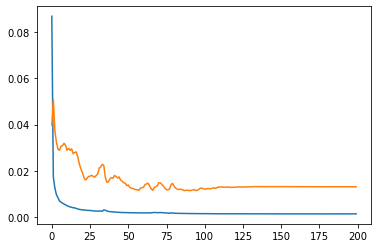

In [220]:
plt.plot(history['train'])
plt.plot(history['val'])

In [221]:
test_losses_heat = []

test_losses_cool = []

test_losses_elec = []

heat_pred_total = []

cool_pred_total = []

elec_pred_heat = []

test_losses = []

for ValidXHeat,ValidYHeat,ValidXCool,ValidYCool,ValidXElec,ValidYElec in tes_dataloader:
                
    seq_inp_heat = ValidXHeat.to(device)
            
    seq_true_heat = ValidYHeat.to(device)
            
    seq_inp_cool = ValidXCool.to(device)
            
    seq_true_cool = ValidYCool.to(device)
            
    seq_inp_elec = ValidXElec.to(device)
            
    seq_true_elec = ValidYElec.to(device)
                
    seq_pred_heat,seq_pred_cool,seq_pred_elec = model(seq_inp_heat,seq_inp_cool,seq_inp_elec)
    
    heat_pred_total.append(seq_pred_heat)
    
    cool_pred_total.append(seq_pred_cool)
    
    elec_pred_heat.append(seq_pred_elec)
    
    loss_heat = criterion(seq_pred_heat,seq_true_heat)
            
    loss_cool = criterion(seq_pred_cool,seq_true_cool)

    loss_elec = criterion(seq_pred_elec,seq_true_elec)
    
    test_losses_heat.append(loss_heat.item())
    
    test_losses_cool.append(loss_cool.item())
    
    test_losses_elec.append(loss_elec.item())
            
    loss = loss_heat + loss_cool + loss_elec     
                
    test_losses.append(loss.item())
    

In [222]:
heat_pred_total = torch.cat(heat_pred_total,dim=0).detach().numpy()
cool_pred_total = torch.cat(cool_pred_total,dim=0).detach().numpy()
elec_pred_heat = torch.cat(elec_pred_heat,dim=0).detach().numpy()


In [224]:
real_pred = heat_test_scaler.inverse_transform(np.repeat(heat_pred_total.flatten().reshape(-1,1),29,axis=1))
real_labs = heat_test_scaler.inverse_transform(np.repeat(heat_tes_lab.flatten().reshape(-1,1),29,axis=1))

In [225]:
print("The heating load MAPE is " + str(mean_absolute_percentage_error(real_labs[:,1],real_pred[:,1])*100) + " %")
print("The heating load RMSE is " + str(mean_squared_error(real_labs[:,1],real_pred[:,1],squared=False)) + " kW")

The heating load MAPE is 6.090857293919761 %
The heating load RMSE is 163.03716339441192 kW


In [226]:
real_pred_cool = cool_test_scaler.inverse_transform(np.repeat(cool_pred_total.flatten().reshape(-1,1),29,axis=1))
real_labs_cool = cool_test_scaler.inverse_transform(np.repeat(cool_tes_lab.flatten().reshape(-1,1),29,axis=1))

In [227]:
print("The cooling load MAPE is " + str(mean_absolute_percentage_error(real_labs_cool[:,2],real_pred_cool[:,2])*100) + " %")
print("The cooling load RMSE is " + str(mean_squared_error(real_labs_cool[:,2],real_pred_cool[:,2],squared=False)) + " kW")

The cooling load MAPE is 6.945306871380449 %
The cooling load RMSE is 1550.0818097532733 kW


In [228]:
real_pred_elec = elec_test_scaler.inverse_transform(np.repeat(elec_pred_heat.flatten().reshape(-1,1),29,axis=1))
real_labs_elec = elec_test_scaler.inverse_transform(np.repeat(elec_tes_lab.flatten().reshape(-1,1),29,axis=1))

In [229]:
print("The electric load MAPE is " + str(mean_absolute_percentage_error(real_labs_elec[:,0],real_pred_elec[:,0])*100) + " %")
print("The electric load RMSE is " + str(mean_squared_error(real_labs_elec[:,0],real_pred_elec[:,0],squared=False)) + " kW")

The electric load MAPE is 3.2302382583778053 %
The electric load RMSE is 786.5625420553486 kW
